### 一.基本思路：局部距离替换高维空间距离

上一节MDS中，我们构建原始高维空间的距离直接采用了欧氏距离，但这在流形结构数据中往往有问题，如下图所示，黑线长度便是欧氏距离，而采用红线来表示距离可能会更加合理
![avatar](./source/19_isomap1.png)
所以核心问题便是如何计算红色线距离，这可以转换为计算近邻图上两点之间的最短距离问题，操作如下：   

（1）对样本中的每个点，保留与它最近的$k$个点（或者$\varepsilon$领域半径内的点）的欧氏距离，而其他点的距离设置为无穷大；   

（2）采用Dijkstra算法或者Floyd算法计算所有样本中任意两点间的最短距离，并更新原始距离矩阵$D$；  

而后面的操作同MDS一样，所以这一节的主要操作便是对$D$再运用一次Dijkstra算法/Floyd算法，关于这俩算法这一节就介绍了，笔者可能会放在后续的《数据结构与算法》项目中再做介绍，哈哈哈~

### 二.代码实现

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [2]:
def floyd(dist_matrix):
    vex_num=len(dist_matrix)  
    for k in range(vex_num):
        for i in range(vex_num):
            for j in range(vex_num):
                if dist_matrix[i][k]==np.inf or dist_matrix[k][j]==np.inf:
                    temp=np.inf
                else:
                    temp=dist_matrix[i][k]+dist_matrix[k][j]
                if dist_matrix[i][j]>temp:
                    dist_matrix[i][j]=temp
    return dist_matrix

造伪数据

In [3]:
n = 200
r = np.linspace(0,1,n)
l = np.linspace(0,1,n)

t = (3 * np.pi) / 2 * ( 1 + 2 * r )
x =  t * np.cos(t)
y = 10 * l
z =t * np.sin(t)
data=np.c_[x,y,z]

构建原始距离矩阵$D$

In [4]:
m=data.shape[0]
D=np.zeros(shape=(m,m))
for i in range(0,m):
    for j in range(i,m):
        D[i,j]=np.sqrt(np.sum(np.power(data[i]-data[j],2)))
        D[j,i]=D[i,j]

使用floyd算法进行更新

In [5]:
epsilon=10#领域半径
D=np.where(D<epsilon,D,np.inf)

In [6]:
D=floyd(D)

使用MDS算法

In [7]:
import os
os.chdir('../')
from ml_models.decomposition import MDS

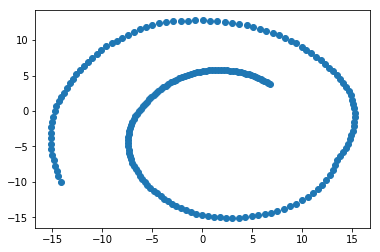

In [8]:
mds = MDS(n_components=2)
new_data = mds.fit_transform(D=D)
plt.scatter(new_data[:, 0], new_data[:, 1])
plt.show()

代码封装一下到`ml_models.decomposition.Isomap`

### 三.问题讨论
显然，Isomap会受到最近邻$k$或者近邻半径$\varepsilon$的影响，选择过大或者过小都有弊端：   

（1）过小，可能会存在“断路”的情况，图中某些区域可能与其他区域不存在连接，直观来看就是距离矩阵通过floyd算法更新后还存在`np.inf`；  

（2）过大，则会存在“短路”的情况，使得距离失真，比如本节最上图中的黑线距离会取代红线距离；

在实际使用时通过后续任务的表现（分类/回归/...任务的具体表现）来选取